# Ridge and Lasso Regression Models

In [67]:
import os
import sys

sys.dont_write_bytecode = True

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from sklearn.model_selection import train_test_split

from dotenv import load_dotenv
load_dotenv()
current_dir = os.getcwd()
prod_dir = os.path.abspath(os.path.join(current_dir, "..", "..", "Prod"))
sys.path.append(prod_dir)

from etl import FrequencyEncoder, CircleOfFifthsEncoding, ConvertNull


In [27]:
DATA_DIR = './Data/'
DATA_FILE = 'spotify_tracks_kaggle_weekly.csv'



In [28]:
data = pd.read_csv(DATA_DIR + DATA_FILE)

Data splitting -> working with predefined $X_{train}$

In [39]:
RANDOM_STATE = 21
TEST_SIZE = 0.1

In [69]:
X = data.drop('popularity', axis=1)
y = data['popularity']

In [70]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

Dropping columns defined in EDA

In [71]:
drop_columns = ['track_id', 'artwork_url', 'track_url', 'track_name', 'album_name']

In [72]:
X_train = X_train.drop(drop_columns, axis=1, errors='ignore')
X_test = X_test.drop(drop_columns, axis=1, errors='ignore')

transformation pipeline

In [73]:
target = 'popularity'

onehot_col = ['language']
circle_of_fifths_col = ['key']
artist_name_col = ['artist_name']

numeric_columns = list(X_train.columns[X_train.dtypes != object].difference(['key', 'mode']))

nan_columns = ['acousticness', 'danceability', 'energy', 'liveness', 'speechiness', 'tempo', 'valence']

In [74]:
numeric_pipeline = Pipeline(steps=[
    ('scaling', StandardScaler())
])

artist_name_pipeline = Pipeline(steps=[
    ('encoding', FrequencyEncoder()),
    ('scaling', StandardScaler())
])


transformations = ColumnTransformer(transformers=[
    
    ('onehot_encoding', OneHotEncoder(sparse_output=False), onehot_col),
    ('trigonometric_encoding', CircleOfFifthsEncoding(), circle_of_fifths_col),
    ('artist_encoding', artist_name_pipeline, artist_name_col),
    ('nummeric_processing', numeric_pipeline, numeric_columns)

], remainder='drop')


preprocessing = Pipeline(steps=[
    ('null_values', ConvertNull(columns=nan_columns)),
    ('transformation', transformations)
])

transformation of data

In [75]:
X_train = pd.DataFrame(preprocessing.fit_transform(X_train))

In [76]:
y_train = y_train.reset_index(drop=True)

In [77]:
# remove Null values
X_train = X_train.dropna()
y_train = y_train[X_train.index]


**RIDGE**

In [78]:
ridge = Ridge()
ridge.fit(X_train, y_train)

Ridge()

In [79]:
y_pred = ridge.predict(X_train)

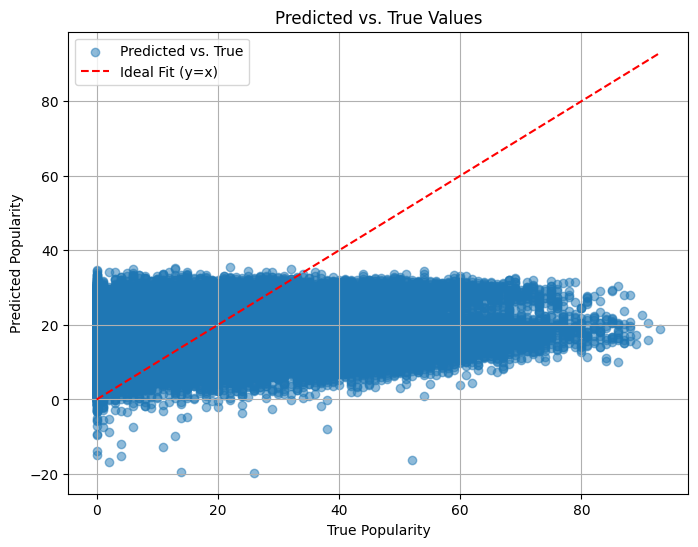

In [84]:
# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_train, y_pred, alpha=0.5, label='Predicted vs. True')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], 'r--', label='Ideal Fit (y=x)')
plt.xlabel('True Popularity')
plt.ylabel('Predicted Popularity')
plt.title('Predicted vs. True Values')
plt.legend()
plt.grid()
plt.show()

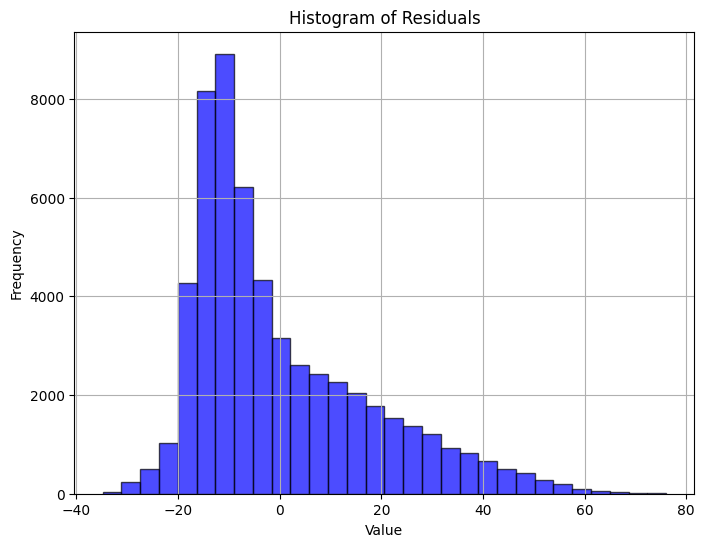

In [88]:
# residuals
residuals = y_train - y_pred

# Histogram - residuals
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.grid()
plt.show()